# Imports

In [0]:
# imports

# Spark SQL Functions
from pyspark.sql.functions import col, when, isnan, isnull, count, regexp_replace, udf, lag, floor
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType

# MLlib
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Spark ML Vector type (used in UDF)
from pyspark.ml.linalg import VectorUDT

# Loading the data

In [0]:
# Adjust the path if yours is slightly different
df = spark.read.csv("/FileStore/tables/Final_Merged_S_P_500_Data.csv", header=True, inferSchema=True)

df.printSchema()
df.show(5)

root
 |-- _c0: integer (nullable = true)
 |-- Date: date (nullable = true)
 |-- Price: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Vol.: string (nullable = true)
 |-- Change %: string (nullable = true)

+----+----------+--------+--------+--------+--------+----+--------+
| _c0|      Date|   Price|    Open|    High|     Low|Vol.|Change %|
+----+----------+--------+--------+--------+--------+----+--------+
|4999|2000-01-03|1,455.20|1,469.20|1,478.00|1,438.40|null|  -0.95%|
|4998|2000-01-04|1,399.40|1,455.20|1,455.20|1,397.40|null|  -3.83%|
|4997|2000-01-05|1,402.10|1,399.40|1,413.30|1,377.70|null|   0.19%|
|4996|2000-01-06|1,403.50|1,402.10|1,411.90|1,392.00|null|   0.10%|
|4995|2000-01-07|1,441.50|1,403.50|1,441.50|1,400.50|null|   2.71%|
+----+----------+--------+--------+--------+--------+----+--------+
only showing top 5 rows



# Streaming Simulation

In [0]:
# Simulate streaming over cleaned data
dates = df.select("Date").distinct().orderBy("Date").rdd.flatMap(lambda x: x).collect()

for d in dates[:5]:  # first 5 days as a test
    print(f"\n Streaming batch for {d}")
    batch_df = df.filter(col("Date") == d)
    batch_df.select("Price", "Open", "High", "Low").summary("mean").show()


 Streaming batch for 2000-01-03
+-------+-----------------+-----------------+------+------------------+
|summary|            Price|             Open|  High|               Low|
+-------+-----------------+-----------------+------+------------------+
|   mean|1455.199951171875|1469.199951171875|1478.0|1438.4000244140625|
+-------+-----------------+-----------------+------+------------------+


 Streaming batch for 2000-01-04
+-------+------------------+-----------------+-----------------+------------------+
|summary|             Price|             Open|             High|               Low|
+-------+------------------+-----------------+-----------------+------------------+
|   mean|1399.4000244140625|1455.199951171875|1455.199951171875|1397.4000244140625|
+-------+------------------+-----------------+-----------------+------------------+


 Streaming batch for 2000-01-05
+-------+------------------+------------------+-----------------+-----------------+
|summary|             Price|       

# EDA

In [0]:
from pyspark.sql.functions import regexp_replace, col

# Remove commas and cast to float for all price columns
df = df.withColumn("High", regexp_replace(col("High"), ",", ""))
df = df.withColumn("High", col("High").cast("float"))

df = df.withColumn("Price", regexp_replace(col("Price"), ",", ""))
df = df.withColumn("Price", col("Price").cast("float"))
df = df.withColumn("Open", regexp_replace(col("Open"), ",", ""))
df = df.withColumn("Open", col("Open").cast("float"))
df = df.withColumn("Low", regexp_replace(col("Low"), ",", ""))
df = df.withColumn("Low", col("Low").cast("float"))



In [0]:
df = df.withColumnRenamed("Vol.", "Volume") # to avoid errors

In [0]:
# Describe numeric columns
df.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------+--------+
|summary|               _c0|             Price|              Open|              High|               Low|Volume|Change %|
+-------+------------------+------------------+------------------+------------------+------------------+------+--------+
|  count|              6381|              6381|              6381|              6381|              6381|     0|    6381|
|   mean|2107.8812098417175|2164.5372159210906|2164.2026309605358| 2176.804392558918|2150.6777578478527|  null|    null|
| stddev|1490.7930388329446|1308.9122401617078| 1308.628364209287|1315.1034366773642|1301.7344528316953|  null|    null|
|    min|                 0|             676.5|             679.3|             695.3|             666.8|  null|  -0.01%|
|    max|              4999|           6144.15|            6134.5|           6147.43|           6111.15|  null|   9.52%|
+-------+------------------+----

In [0]:
from pyspark.sql.functions import year, month, avg, to_date, col


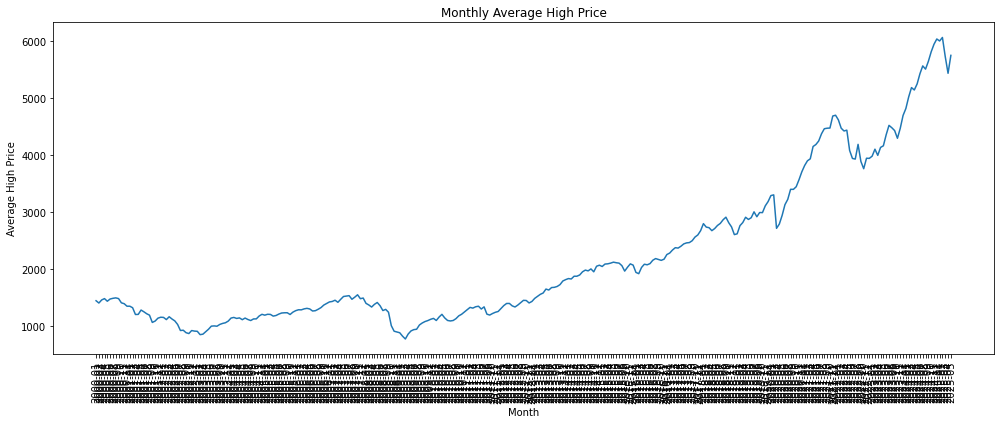

In [0]:
from pyspark.sql.functions import year, month, avg, to_date, col

# Add Year and Month columns
df_month = df.withColumn("Year", year("Date")).withColumn("Month", month("Date"))

# Group by Year and Month, compute average High
monthly_high = (
    df_month.groupBy("Year", "Month")
    .agg(avg("High").alias("AvgHigh"))
    .orderBy("Year", "Month")
    .rdd
    .map(lambda row: (f"{row['Year']}-{row['Month']:02d}", row["AvgHigh"]))
    .collect()
)

months, avg_highs = zip(*monthly_high)

import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.plot(months, avg_highs)
plt.xlabel('Month')
plt.ylabel('Average High Price')
plt.title('Monthly Average High Price')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Data cleaning

In [0]:
# Drop index and rename columns
df_clean = df.drop("_c0") \
    .withColumnRenamed("Vol.", "Volume") \
    .withColumnRenamed("Change %", "Change_Pct")

# Clean and convert to DoubleType
numeric_columns = ["Price", "Open", "High", "Low", "Volume", "Change_Pct"]

for col_name in numeric_columns:
    cleaned_col = regexp_replace(col(col_name), ",", "")
    if col_name == "Change_Pct":
        cleaned_col = regexp_replace(cleaned_col, "%", "")
    df_clean = df_clean.withColumn(col_name, cleaned_col.cast(DoubleType()))

# Check schema and preview
df_clean.printSchema()
df_clean.show(5)


root
 |-- Date: date (nullable = true)
 |-- Price: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Change_Pct: double (nullable = true)

+----------+------+------+------+------+------+----------+
|      Date| Price|  Open|  High|   Low|Volume|Change_Pct|
+----------+------+------+------+------+------+----------+
|2000-01-03|1455.2|1469.2|1478.0|1438.4|  null|     -0.95|
|2000-01-04|1399.4|1455.2|1455.2|1397.4|  null|     -3.83|
|2000-01-05|1402.1|1399.4|1413.3|1377.7|  null|      0.19|
|2000-01-06|1403.5|1402.1|1411.9|1392.0|  null|       0.1|
|2000-01-07|1441.5|1403.5|1441.5|1400.5|  null|      2.71|
+----------+------+------+------+------+------+----------+
only showing top 5 rows



In [0]:
# Data Overview 
n_rows = df_clean.count()
n_cols = len(df_clean.columns)
print(f"Shape: ({n_rows}, {n_cols})")

print("\nSchema:")
df_clean.printSchema()

print("\nSummary statistics:")
df_clean.describe().show()


Shape: (6381, 7)

Schema:
root
 |-- Date: date (nullable = true)
 |-- Price: double (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Volume: double (nullable = true)
 |-- Change_Pct: double (nullable = true)


Summary statistics:
+-------+-----------------+------------------+------------------+------------------+------+--------------------+
|summary|            Price|              Open|              High|               Low|Volume|          Change_Pct|
+-------+-----------------+------------------+------------------+------------------+------+--------------------+
|  count|             6381|              6381|              6381|              6381|     0|                6381|
|   mean| 2164.53721517003| 2164.202632816173| 2176.804392728415|2150.6777589719463|  null|0.029260304027581886|
| stddev|1308.912238509066|1308.6283670615232|1315.1034378924674|1301.7344546369168|  null|   1.230067887404203|
|    min|  

# EDA

In [0]:
from pyspark.sql.functions import year, month, avg, to_date, col


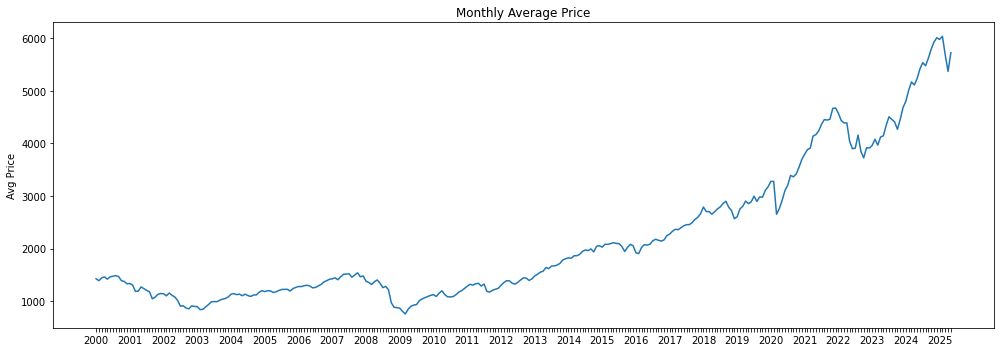

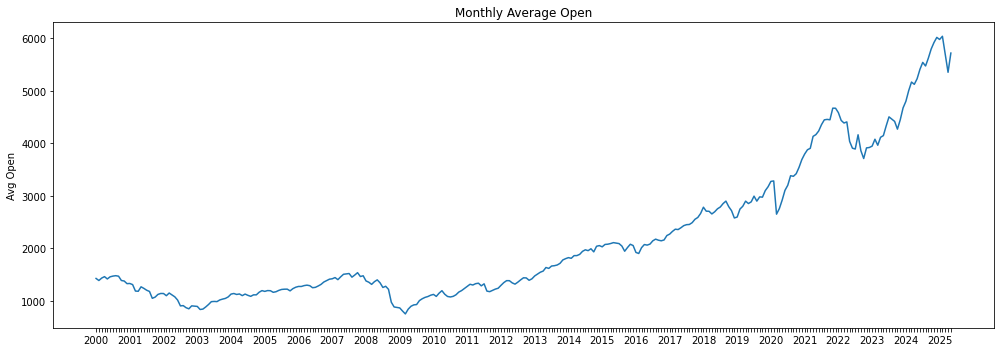

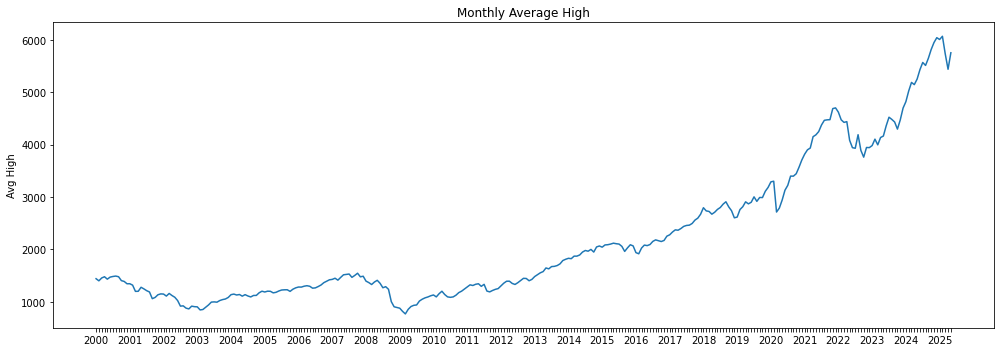

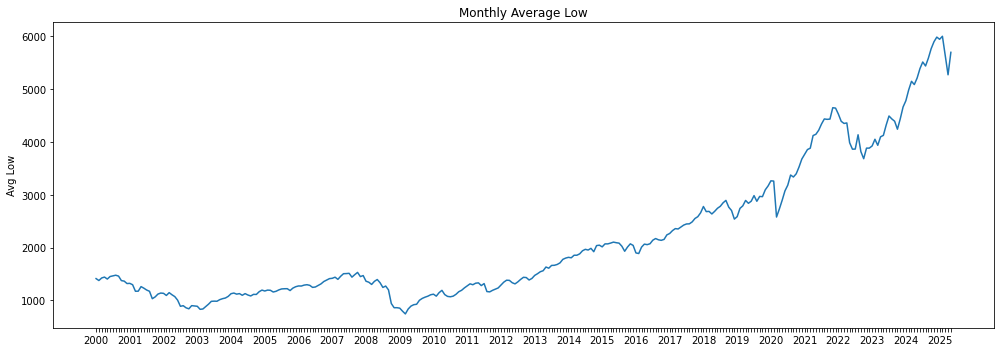

In [0]:
# Adding Year and Month columns
df_month = df.withColumn("Year", year("Date")).withColumn("Month", month("Date"))

# Columns to plot
columns = ["Price", "Open", "High", "Low"]

import matplotlib.pyplot as plt

for column in columns:
    # Group by Year and Month, compute average for each column
    monthly_avg = (
        df_month.groupBy("Year", "Month")
        .agg(avg(col(column)).alias(f"Avg_{column}"))
        .orderBy("Year", "Month")
        .rdd
        .map(lambda row: (row["Year"], row["Month"], row[f"Avg_{column}"]))
        .collect()
    )

    years, months, avg_vals = zip(*monthly_avg)

    # Show year label only where month == 1 (January) so that we can identify where every year starts and ends
    xticks = [f"{year}" if month == 1 else "" for year, month in zip(years, months)]

    plt.figure(figsize=(14,5))
    plt.plot(avg_vals, linestyle='-')
    plt.xlabel('')  # Remove x-axis label
    plt.ylabel(f'Avg {column}')
    plt.title(f'Monthly Average {column}')
    plt.xticks(ticks=range(len(avg_vals)), labels=xticks, rotation=0)
    plt.tight_layout()
    plt.show()


## Checking for missing values

In [0]:

# Total rows
total_rows = df_clean.count()

# Data types as dictionary
types = dict(df_clean.dtypes)

# Separate numeric vs. non-numeric columns
numeric_cols = [c for c in df_clean.columns if types[c] in ['double', 'float']]
non_numeric_cols = [c for c in df_clean.columns if types[c] not in ['double', 'float']]

# Count nulls and NaNs for numeric columns
numeric_counts = [count(when(isnull(col(c)) | isnan(col(c)), c)).alias(c) for c in numeric_cols]

# Count nulls only for non-numeric columns
non_numeric_counts = [count(when(isnull(col(c)), c)).alias(c) for c in non_numeric_cols]

# Combine and compute percentages
null_counts = df_clean.select(numeric_counts + non_numeric_counts).collect()[0].asDict()
missing_percent = {k: f"{(v / total_rows) * 100:.2f}%" for k, v in null_counts.items()}

# Display result
print("Missing value percentages per column:")
for col_name, pct in missing_percent.items():
    print(f"{col_name}: {pct}")


Missing value percentages per column:
Price: 0.00%
Open: 0.00%
High: 0.00%
Low: 0.00%
Volume: 100.00%
Change_Pct: 0.00%
Date: 0.00%


In [0]:
# Since "Volume" has 100% missing values we decided to drop the column
df_clean = df_clean.drop("Volume")


# Feature Engineering


In this step, we prepared the data for modeling by creating new features and defining our prediction target.

- **Sorting by Date**: The dataset was ordered chronologically to ensure that lag features reflect the correct time order.
  
- **Lag Features**: We generated lagged versions of key variables (`Price`, `Open`, `High`, `Low`, `Change_Pct`) using Spark's window functions. These features capture information from the previous day and help the model recognize temporal patterns.

- **Target Variable (`label`)**: A binary column was created to indicate whether the stock price increased the next day. It is defined as:
  - `1` if `Change_Pct > 0` (price went up)
  - `0` otherwise (price went down or stayed the same)

- **Handling Nulls**: The first row(s) resulting from the lag operations contain `null` values and were removed using `dropna()` to ensure clean training data.

The result is a new DataFrame (`df_model`) with both predictive features and the target variable ready for machine learning model training.


In [0]:
df_clean = df_clean.orderBy("Date")

In [0]:
# Define the window by date
window_spec = Window.orderBy("Date")

# Create lag features
df_lagged = df_clean \
    .withColumn("Lag_Price", lag("Price", 1).over(window_spec)) \
    .withColumn("Lag_Open", lag("Open", 1).over(window_spec)) \
    .withColumn("Lag_High", lag("High", 1).over(window_spec)) \
    .withColumn("Lag_Low", lag("Low", 1).over(window_spec)) \
    .withColumn("Lag_Change", lag("Change_Pct", 1).over(window_spec))


In [0]:
# Create binary label based on Change_Pct
df_lagged = df_lagged.withColumn(
    "label", when(col("Change_Pct") > 0, 1).otherwise(0)
)

In [0]:
# Drop the nulls (from lag rows)
df_model = df_lagged.dropna()

In [0]:
# Quick sanity check
df_model.select("Date", "label", "Price", "Lag_Price", "Lag_Open", "Lag_Change","label").show(5)

+----------+-----+------+---------+--------+----------+-----+
|      Date|label| Price|Lag_Price|Lag_Open|Lag_Change|label|
+----------+-----+------+---------+--------+----------+-----+
|2000-01-04|    0|1399.4|   1455.2|  1469.2|     -0.95|    0|
|2000-01-05|    1|1402.1|   1399.4|  1455.2|     -3.83|    1|
|2000-01-06|    1|1403.5|   1402.1|  1399.4|      0.19|    1|
|2000-01-07|    1|1441.5|   1403.5|  1402.1|       0.1|    1|
|2000-01-10|    1|1457.6|   1441.5|  1403.5|      2.71|    1|
+----------+-----+------+---------+--------+----------+-----+
only showing top 5 rows



In [0]:
# List of features to use for modeling
feature_cols = ["Lag_Price", "Lag_Open", "Lag_High", "Lag_Low", "Lag_Change"]

# Assemble into a single features column
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_final = assembler.transform(df_model)


In [0]:
# Split the data into train-test
train_data, test_data = df_final.randomSplit([0.8, 0.2], seed=42)

# Modeling

## Logistic Regression


We trained a logistic regression model to predict whether the stock price would increase the next day. The model used lag-based features derived from historical price metrics.

- **ROC AUC Score**: 0.52 (close to random guessing, indicating low predictive power)
- **Confusion Matrix**: Helps visualize the number of correct vs. incorrect predictions for each class

Despite being simple and interpretable, the logistic regression model underperformed, suggesting the underlying pattern is non-linear or requires more complex features.


In [0]:
lr = LogisticRegression(featuresCol="features", labelCol="label")
lr_model = lr.fit(train_data)


In [0]:
# Predict on test data
predictions = lr_model.transform(test_data)

# Evaluate accuracy
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
roc_auc = evaluator.evaluate(predictions)

print(f"ROC AUC on test set: {roc_auc:.4f}")

ROC AUC on test set: 0.5222


In [0]:
# Confusion matrix
predictions.groupBy("label", "prediction").count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       1.0|  601|
|    0|       1.0|  514|
|    1|       0.0|   47|
|    0|       0.0|   57|
+-----+----------+-----+



In [0]:
display(predictions.groupBy("label", "prediction").count())

label,prediction,count
1,1.0,601
0,1.0,514
1,0.0,47
0,0.0,57


## Random Forest

We trained a Random Forest classifier using Spark MLlib to capture non-linear relationships between lagged price features and next-day market direction. The model was evaluated using ROC AUC and confusion matrix.

#### Steps:
- **Baseline Random Forest**: Trained with default parameters (`numTrees=100`)
- **Feature Importance**: Identified `Lag_Change` as the most influential feature.
- **Hyperparameter Tuning**: Used 3-fold cross-validation to search over `numTrees` and `maxDepth`.
- **Evaluation Metric**: ROC AUC was used to assess performance across all models.

#### Results:
| Model                     | ROC AUC |
|--------------------------|---------|
| Logistic Regression       | 0.5222  |
| Random Forest (untuned)   | 0.5227  |
| Random Forest (tuned)     | 0.5273  |

While all models performed slightly above random, the Random Forest (tuned) performed best. However, performance indicates potential data limitations or the need for richer feature engineering.


In [0]:
# Train the Random Forest
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)
rf_model = rf.fit(train_data)


In [0]:
# Make predictions
rf_predictions = rf_model.transform(test_data)

# Evaluate with ROC AUC
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Random Forest ROC AUC: {rf_auc:.4f}")

Random Forest ROC AUC: 0.5227


In [0]:
# Print feature importances
for feature, importance in zip(feature_cols, rf_model.featureImportances):
    print(f"{feature}: {importance:.4f}")


Lag_Price: 0.1460
Lag_Open: 0.1212
Lag_High: 0.1529
Lag_Low: 0.1202
Lag_Change: 0.4597


In [0]:
# Confusion matrix
rf_predictions.groupBy("label", "prediction").count().show()


+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       1.0|  508|
|    0|       1.0|  438|
|    1|       0.0|  140|
|    0|       0.0|  133|
+-----+----------+-----+



In [0]:
display(rf_predictions.groupBy("label", "prediction").count())

label,prediction,count
1,1.0,508
0,1.0,438
1,0.0,140
0,0.0,133


In [0]:
# Reuse evaluator from before
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

# Param grid for Random Forest
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# CrossValidator setup
cv = CrossValidator(estimator=rf,
                    estimatorParamMaps=param_grid,
                    evaluator=evaluator,
                    numFolds=3)

# Train model using CV
cv_model = cv.fit(train_data)

# Predict and evaluate
cv_predictions = cv_model.transform(test_data)
cv_auc = evaluator.evaluate(cv_predictions)
print(f"Tuned Random Forest ROC AUC: {cv_auc:.4f}")


Tuned Random Forest ROC AUC: 0.5273


In [0]:
# UDF to extract probability of class 1 from DenseVector
def extract_prob(v):
    return float(v[1])

extract_prob_udf = udf(extract_prob, DoubleType())

# Apply UDF and create probability bucket
cv_buckets = cv_predictions.select(
    col("label").alias("Label"),
    extract_prob_udf(col("probability")).alias("Predicted_Probability")
).withColumn("bucket", floor(col("Predicted_Probability") * 10) / 10)

# Count by bucket and label
cv_bucket_stats = cv_buckets.groupBy("bucket", "Label").count().orderBy("bucket")

# Visualize
display(cv_bucket_stats)


bucket,Label,count
0.3,0,1
0.4,0,139
0.4,1,150
0.5,0,418
0.5,1,483
0.6,0,13
0.6,1,15


In [0]:
print(f"Logistic Regression ROC AUC: {roc_auc:.4f}")
print(f"Random Forest (untuned) ROC AUC: {rf_auc:.4f}")
print(f"Tuned Random Forest ROC AUC: {cv_auc:.4f}")


Logistic Regression ROC AUC: 0.5222
Random Forest (untuned) ROC AUC: 0.5227
Tuned Random Forest ROC AUC: 0.5273


# Conclusion

This project explored the use of Big Data tools for stock market direction prediction using Apache Spark MLlib.

We built a scalable pipeline that included:
- Efficient **data loading and cleaning** of historical S&P 500 prices
- **Feature engineering** with lag variables to capture temporal dependencies
- **Binary classification models** to predict whether the stock price would rise the next day

Three models were compared:
- **Logistic Regression** (baseline)
- **Random Forest** (untuned)
- **Random Forest with cross-validation and hyperparameter tuning**

All models were evaluated using **ROC AUC**, and visualized through:
- **Confusion matrices**
- **Probability bucket plots** to approximate ROC behavior (Databricks-native)

### Key Findings:
- **Model performance was modest**, with ROC AUC scores around 0.52–0.53
- **Lagged daily percentage change (Lag_Change)** was consistently the most important feature
- Even with tuning, predicting short-term market direction remains a challenging task with price data alone

### Future Directions:
To improve results, future work could incorporate:
- **Macroeconomic indicators** (interest rates, CPI, etc.)
- **Sentiment analysis** from news or social media
- **Technical indicators** like moving averages or RSI
- **Streaming pipelines** to test the model in near real-time

This project demonstrates the power of Apache Spark for end-to-end machine learning workflows and reinforces the value of thoughtful data engineering and model evaluation when working with real-world time series problems.
